# Introduction to Spark lab, part 2: Querying data
This notebook guides you through querying data with Spark, including how to create and use DataFrames, run SQL queries, apply functions to the results of SQL queries, join data from different data sources, and visualize data in graphs.

This notebook uses pySpark, the Python API for Spark. Some knowledge of Python is recommended. This notebook runs on Python and Spark.

If you are new to Spark, see the first module in this series: <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/95811fca38af4ccbea8acf8658bedcfc" target="_blank" rel="noopener noreferrer">Introduction to Spark, part 1: Basic Concepts</a>.

## Table of contents

1. [Prepare the environment and the data](#getstarted)<br>
     1.1 [Enable SQL processing](#sqlprocessing)<br>
     1.2 [Download the data](#download)<br>
     1.3 [Create a DataFrame](#createdf)<br>
     1.4 [Create a table](#createtab)<br>
2. [Run SQL queries](#runsql)<br>
    2.1 [Display query results with a pandas DataFrame](#pandas)<br>
    2.2 [Run a group by query](#groupby)<br>
    2.3 [Run a subselect query](#subselect)<br>
    2.4 [Return nested JSON field values](#nested)<br>
3. [Convert RDDs to DataFrames](#convertrdd)<br>
    3.1 [Create a simple RDD](#simplerdd)<br>
    3.2 [Apply a schema](#apply)<br>
    3.3 [Create rows with named columns](#namedcol)<br>
    3.4 [Join tables](#join)<br>
4. [Create SQL functions](#sqlfuncs)<br>
5. [Convert a pandas DataFrame to a Spark DataFrame](#sparkdf)<br>
    5.1 [Get a new data set](#ufo)<br>
    5.2 [Create a pandas DataFrame](#ufopandas)<br>
    5.3 [Convert to a Spark DataFrame](#sparkufo)<br>
    5.4 [Run an SQL statement](#runufo)<br>
6. [Visualize data](#viz)<br>
    6.1 [Create a chart using Pandas](#vizchart)<br>
    6.2 [Aggregate the data](#vizagg)<br>
    6.3 [Create a chart using Spark SQL](#vizchart2)<br>
7. [Summary and next steps](#nextsteps)

<a id="getstarted"></a>
## 1. Prepare the environment and the data
Before you can run SQL queries on data in a Spark environment, you need to enable SQL processing and then move the data to the structured format of a DataFrame.

<a id="sqlprocessing"></a>
### 1.1 Enable SQL processing
The preferred method to enable SQL processing with Spark 2.0 is to use the new SparkSession object, but you can also create a SQLContext object. 

Use the predefined Spark Context, `sc`, which contains the connection information for Spark, to create an SQLContext:

In [1]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190629195823-0001
KERNEL_ID = 4af820ce-5eb1-4825-86a2-5a56edcc7572


<a id="download"></a>
### 1.2 Download the data file

You'll download a JSON file with data about world banks from GitHub. The data is adapted from this data set: <a href="http://data.worldbank.org/data-catalog/projects-portfolio" target="_blank" rel="noopener noreferrer">http://data.worldbank.org/data-catalog/projects-portfolio</a>.

Remove any files with the same name as the file that you're going to download and then download the file from a URL:

In [2]:
!rm world_bank.json.gz -f
!wget https://raw.githubusercontent.com/bradenrc/sparksql_pot/master/world_bank.json.gz

--2019-06-29 19:58:33--  https://raw.githubusercontent.com/bradenrc/sparksql_pot/master/world_bank.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 446287 (436K) [application/octet-stream]
Saving to: 'world_bank.json.gz'

world_bank.json.gz  100%[===================>] 435.83K  --.-KB/s    in 0.02s   

2019-06-29 19:58:33 (21.7 MB/s) - 'world_bank.json.gz' saved [446287/446287]



<a id="createdf"></a>
### 1.3 Create a DataFrame 

Instead of creating an RDD to read the file, you'll create a Spark DataFrame. Unlike an RDD, a DataFrame creates a schema around the data, which supplies the necessary structure for SQL queries. A self-describing format like JSON is ideal for DataFrames, but many other file types are supported, including text (CSV) and Parquet.

Create a DataFrame:

In [3]:
example1_df = sqlContext.read.json("world_bank.json.gz")

Print the schema to see how Spark SQL inferred the shape of the data:

In [4]:
print (example1_df.printSchema())

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- approvalfy: string (nullable = true)
 |-- board_approval_month: string (nullable = true)
 |-- boardapprovaldate: string (nullable = true)
 |-- borrower: string (nullable = true)
 |-- closingdate: string (nullable = true)
 |-- country_namecode: string (nullable = true)
 |-- countrycode: string (nullable = true)
 |-- countryname: string (nullable = true)
 |-- countryshortname: string (nullable = true)
 |-- docty: string (nullable = true)
 |-- envassesmentcategorycode: string (nullable = true)
 |-- grantamt: long (nullable = true)
 |-- ibrdcommamt: long (nullable = true)
 |-- id: string (nullable = true)
 |-- idacommamt: long (nullable = true)
 |-- impagency: string (nullable = true)
 |-- lendinginstr: string (nullable = true)
 |-- lendinginstrtype: string (nullable = true)
 |-- lendprojectcost: long (nullable = true)
 |-- majorsector_percent: array (nullable = true)
 |    |-- element: struct (containsNu

Now look at the first two rows of data.

You can run the simple command `print example1_df.take(2)`, however, for readability, run the following command to include a row of asterisks in between the data rows:

In [5]:
for row in example1_df.take(2):
    print (row)
    print ("*" * 20)

Row(_id=Row($oid='52b213b38594d8a2be17c780'), approvalfy='1999', board_approval_month='November', boardapprovaldate='2013-11-12T00:00:00Z', borrower='FEDERAL DEMOCRATIC REPUBLIC OF ETHIOPIA', closingdate='2018-07-07T00:00:00Z', country_namecode='Federal Democratic Republic of Ethiopia!$!ET', countrycode='ET', countryname='Federal Democratic Republic of Ethiopia', countryshortname='Ethiopia', docty='Project Information Document,Indigenous Peoples Plan,Project Information Document', envassesmentcategorycode='C', grantamt=0, ibrdcommamt=0, id='P129828', idacommamt=130000000, impagency='MINISTRY OF EDUCATION', lendinginstr='Investment Project Financing', lendinginstrtype='IN', lendprojectcost=550000000, majorsector_percent=[Row(Name='Education', Percent=46), Row(Name='Education', Percent=26), Row(Name='Public Administration, Law, and Justice', Percent=16), Row(Name='Education', Percent=12)], mjsector_namecode=[Row(code='EX', name='Education'), Row(code='EX', name='Education'), Row(code='BX

<a id="createtab"></a>
### 1.4 Create a table 

SQL statements must be run against a table. Create a table that's a pointer to the DataFrame:

In [6]:
example1_df.registerTempTable("world_bank")

<a id="runsql"></a>
## 2. Run SQL queries

You must define a new DataFrame for the results of the SQL query and put the SQL statement inside the `sqlContext.sql()` method.

Run the following cell to select all columns from the table and print information about the resulting DataFrame and schema of the data:

In [7]:
temp_df =  sqlContext.sql("select * from world_bank")

print (type(temp_df))
print ("*" * 20)
print (temp_df)

<class 'pyspark.sql.dataframe.DataFrame'>
********************
DataFrame[_id: struct<$oid:string>, approvalfy: string, board_approval_month: string, boardapprovaldate: string, borrower: string, closingdate: string, country_namecode: string, countrycode: string, countryname: string, countryshortname: string, docty: string, envassesmentcategorycode: string, grantamt: bigint, ibrdcommamt: bigint, id: string, idacommamt: bigint, impagency: string, lendinginstr: string, lendinginstrtype: string, lendprojectcost: bigint, majorsector_percent: array<struct<Name:string,Percent:bigint>>, mjsector_namecode: array<struct<code:string,name:string>>, mjtheme: array<string>, mjtheme_namecode: array<struct<code:string,name:string>>, mjthemecode: string, prodline: string, prodlinetext: string, productlinetype: string, project_abstract: struct<cdata:string>, project_name: string, projectdocs: array<struct<DocDate:string,DocType:string,DocTypeDesc:string,DocURL:string,EntityID:string>>, projectfinancialty

The first `print` command shows that the DataFrame is a Spark DataFrame. The last `print` command shows the column names and data types of the DataFrame.

<a id="pandas"></a>
### 2.1 Display query results with a pandas DataFrame
The `print` command doesn't show the data in a useful format. Instead of creating a Spark DataFrame, use the pandas open-source data analytics library to create a pandas DataFrame that shows the data in a table. 

Import the pandas library and use the `.toPandas()` method to show the query results:

In [8]:
import pandas as pd
sqlContext.sql("select id, borrower from world_bank limit 2").toPandas()

,id,borrower
0,P129828,FEDERAL DEMOCRATIC REPUBLIC OF ETHIOPIA
1,P144674,GOVERNMENT OF TUNISIA


<a id="groupby"></a>
### 2.2 Run a group by query

You can make your SQL queries easier to read by using the `query` keyword and surrounding the SQL query with `"""` on separate lines. 

Calculate a count of projects by region:

In [9]:
query = """
select
    regionname ,
    count(*) as project_count
from world_bank
group by regionname 
order by count(*) desc
"""

sqlContext.sql(query).toPandas()

,regionname,project_count
0,Africa,152
1,East Asia and Pacific,100
2,Europe and Central Asia,74
3,South Asia,65
4,Middle East and North Africa,54
5,Latin America and Caribbean,53
6,Other,2


<a id="subselect"></a>
### 2.3 Run a subselect query
You can run subselect queries.

Calculate a count of projects by region again, but this time using a subselect:

In [10]:
query = """

select * from
    (select
        regionname ,
        count(*) as project_count
    from world_bank
    group by regionname 
    order by count(*) desc) table_alias
limit 2
"""

sqlContext.sql(query).toPandas()

,regionname,project_count
0,Africa,152
1,East Asia and Pacific,100


<a id="nested"></a>
### 2.4 Return nested JSON field values
With JSON data, you can select the values of nested fields with dot notation.

Print the schema so that you can see that `sector.Name` is a nested field and then select its first two values:

In [11]:
example1_df.printSchema()

sql = "select sector.Name from world_bank limit 2"
sqlContext.sql(sql).show()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- approvalfy: string (nullable = true)
 |-- board_approval_month: string (nullable = true)
 |-- boardapprovaldate: string (nullable = true)
 |-- borrower: string (nullable = true)
 |-- closingdate: string (nullable = true)
 |-- country_namecode: string (nullable = true)
 |-- countrycode: string (nullable = true)
 |-- countryname: string (nullable = true)
 |-- countryshortname: string (nullable = true)
 |-- docty: string (nullable = true)
 |-- envassesmentcategorycode: string (nullable = true)
 |-- grantamt: long (nullable = true)
 |-- ibrdcommamt: long (nullable = true)
 |-- id: string (nullable = true)
 |-- idacommamt: long (nullable = true)
 |-- impagency: string (nullable = true)
 |-- lendinginstr: string (nullable = true)
 |-- lendinginstrtype: string (nullable = true)
 |-- lendprojectcost: long (nullable = true)
 |-- majorsector_percent: array (nullable = true)
 |    |-- element: struct (containsNu

<a id="convertrdd"></a>
## 3. Convert RDDs to DataFrames
If you want to run SQL queries on an existing RDD, you must convert the RDD to a DataFrame. The main difference between RDDs and DataFrames is whether the columns are named.

You'll create an RDD and then convert it to a DataFrame in two different ways:
 - [Apply a schema](#apply)
 - [Create rows with named columns](#namedcol)

<a id="simplerdd"></a>
### 3.1 Create a simple RDD
You'll create a simple RDD with an ID column and two columns of random numbers.

First create a Python list of lists:

In [12]:
import random

data_e2 = []
for x in range(1,6):
    random_int = int(random.random() * 10)
    data_e2.append([x, random_int, random_int^2])

Now create the RDD:

In [13]:
rdd_example2 = sc.parallelize(data_e2)
print (rdd_example2.collect())

[[1, 1, 3], [2, 3, 1], [3, 1, 3], [4, 8, 10], [5, 0, 2]]


<a id="apply"></a>
### 3.2 Apply a schema
You'll use the `StructField` method to create a schema object that's based on a string, apply the schema to the RDD to create a DataFrame, and then create a table to run SQL queries on.

Define your schema columns as a string:

In [14]:
from pyspark.sql.types import *

schemaString = "ID VAL1 VAL2"

Assign header information with the `StructField` method and create the schema with the `StructType` method:

In [15]:
fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
schema = StructType(fields)

Apply the schema to the RDD with the `createDataFrame` method:

In [16]:
schemaExample = sqlContext.createDataFrame(rdd_example2, schema)

Register the DataFrame as a table:

In [17]:
schemaExample.registerTempTable("example2")

View the data:

In [18]:
print (schemaExample.collect())

[Row(ID='1', VAL1='1', VAL2='3'), Row(ID='2', VAL1='3', VAL2='1'), Row(ID='3', VAL1='1', VAL2='3'), Row(ID='4', VAL1='8', VAL2='10'), Row(ID='5', VAL1='0', VAL2='2')]


You can reference the columns names in DataFrames:

In [19]:
for row in schemaExample.take(2):
    print (row.ID, row.VAL1, row.VAL2)

1 1 3
2 3 1


Run a simple SQL query:

In [20]:
sqlContext.sql("select * from example2").toPandas()

,ID,VAL1,VAL2
0,1,1,3
1,2,3,1
2,3,1,3
3,4,8,10
4,5,0,2


<a id="namedcol"></a>
### 3.3 Create rows with named columns
You'll create an RDD with named columns and then convert it to a DataFrame and a table.

Create a new RDD and specify the names of the columns with the `map` method:

In [21]:
from pyspark.sql import Row

rdd_example3 = rdd_example2.map(lambda x: Row(id=x[0], val1=x[1], val2=x[2]))

print (rdd_example3.collect())                                                         

[Row(id=1, val1=1, val2=3), Row(id=2, val1=3, val2=1), Row(id=3, val1=1, val2=3), Row(id=4, val1=8, val2=10), Row(id=5, val1=0, val2=2)]


Convert `rdd_example3` to a DataFrame and register an associated table:

In [22]:
df_example3 = rdd_example3.toDF()
df_example3.registerTempTable("example3")

Run a simple SQL query:

In [23]:
sqlContext.sql("select * from example3").toPandas()

,id,val1,val2
0,1,1,3
1,2,3,1
2,3,1,3
3,4,8,10
4,5,0,2


<a id="join"></a>
### 3.4 Join tables
You can join tables.

Join tables `example2` and `example3` on the ID column:

In [24]:
query = """
select
    *
from
    example2 e2
inner join example3 e3 on
    e2.ID = e3.id
"""

print (sqlContext.sql(query).toPandas())

  ID VAL1 VAL2  id  val1  val2
0  5    0    2   5     0     2
1  1    1    3   1     1     3
2  3    1    3   3     1     3
3  2    3    1   2     3     1
4  4    8   10   4     8    10


Alternatively, you can join DataFrames with a Python command instead of an SQL query:

In [25]:
df_example4 = df_example3.join(schemaExample, schemaExample["ID"] == df_example3["id"] )

for row in df_example4.take(5):
    print (row)

Row(id=5, val1=0, val2=2, ID='5', VAL1='0', VAL2='2')
Row(id=1, val1=1, val2=3, ID='1', VAL1='1', VAL2='3')
Row(id=3, val1=1, val2=3, ID='3', VAL1='1', VAL2='3')
Row(id=2, val1=3, val2=1, ID='2', VAL1='3', VAL2='1')
Row(id=4, val1=8, val2=10, ID='4', VAL1='8', VAL2='10')


<a id="sqlfuncs"></a>
## 4. Create SQL functions 
You can create functions that run in SQL queries. 

First, create a Python function and test it:

In [26]:
def simple_function(v):
    return int(v * 10)

#test the function
print (simple_function(3))

30


Next, register the function as an SQL function with the `registerFunction` method:

In [27]:
sqlContext.registerFunction("simple_function", simple_function)

<function __main__.simple_function>

Now run the function in an SQL Statement:

In [28]:
query = """
select
    ID,
    VAL1,
    VAL2,
    simple_function(VAL1) as s_VAL1,
    simple_function(VAL2) as s_VAL2
from
 example2
"""
sqlContext.sql(query).toPandas()

,ID,VAL1,VAL2,s_VAL1,s_VAL2
0,1,1,3,1111111111,3333333333
1,2,3,1,3333333333,1111111111
2,3,1,3,1111111111,3333333333
3,4,8,10,8888888888,10101010101010101010
4,5,0,2,0,2222222222


The values in the VAL1 and VAL2 columns look like strings (10 characters instead of a number multiplied by 10). That's because string is the default data type for columns in Spark DataFrames.

Cast the values in the VAL1 and VAL2 columns to integers: 

In [29]:
query = """
select
    ID,
    VAL1,
    VAL2,
    simple_function(cast(VAL1 as int)) as s_VAL1,
    simple_function(cast(VAL2 as int)) as s_VAL2
from
 example2
"""
sqlContext.sql(query).toPandas()

,ID,VAL1,VAL2,s_VAL1,s_VAL2
0,1,1,3,10,30
1,2,3,1,30,10
2,3,1,3,10,30
3,4,8,10,80,100
4,5,0,2,0,20


That looks better!

<a id="sparkdf"></a>
## 5. Convert a pandas DataFrame to a Spark DataFrame
Although pandas DataFrames display data in a friendlier format, Spark DataFrames can be faster and more scalable.

You'll get a new data set, create a pandas DataFrame for it, and then convert the pandas DataFrame to a Spark DataFrame.

<a id="ufo"></a>
### 5.1 Get a new data set
Get a data set about anonymous outdoor equipment purchase data:

In [30]:
!rm GoSales_Tx.csv -f
!wget https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spark/product-line-prediction/data/GoSales_Tx.csv

--2019-06-29 20:02:01--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/spark/product-line-prediction/data/GoSales_Tx.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2470333 (2.4M) [text/plain]
Saving to: 'GoSales_Tx.csv'

GoSales_Tx.csv      100%[===================>]   2.36M  --.-KB/s    in 0.05s   

2019-06-29 20:02:02 (47.6 MB/s) - 'GoSales_Tx.csv' saved [2470333/2470333]



<a id="ufopandas"></a>
### 5.2 Create a pandas DataFrame
Create a pandas DataFrame of the data set with the `read_csv` method:

In [31]:
pandas_df = pd.read_csv("./GoSales_Tx.csv")
pandas_df.head()

,GENDER,AGE,MARITAL_STATUS,PROFESSION,PRODUCT_LINE
0,M,27,Single,Professional,Personal Accessories
1,F,39,Single,Executive,Personal Accessories
2,M,39,Married,Student,Mountaineering Equipment
3,F,56,Single,Hospitality,Personal Accessories
4,M,45,Married,Retired,Golf Equipment


<a id="sparkufo"></a>
### 5.3 Convert to a Spark DataFrame
Convert the pandas DataFrame to a Spark DataFrame with the `createDataFrame` method. Remember using the `createDataFrame` method to convert an RDD to a Spark DataFrame?

In [32]:
spark_df = sqlContext.createDataFrame(pandas_df)

Print the first two rows:

In [33]:
spark_df.show(2)

+------+---+--------------+------------+--------------------+
|GENDER|AGE|MARITAL_STATUS|  PROFESSION|        PRODUCT_LINE|
+------+---+--------------+------------+--------------------+
|     M| 27|        Single|Professional|Personal Accessories|
|     F| 39|        Single|   Executive|Personal Accessories|
+------+---+--------------+------------+--------------------+
only showing top 2 rows



Register the Spark DataFrame as a table:

In [34]:
spark_df.registerTempTable("gosales_tx")

<a id="runufo"></a>
### 5.4 Run an SQL statement
Now run an SQL statement to print the first 10 rows of the table:

In [35]:
print(sqlContext.sql("select * from gosales_tx limit 10").collect())

[Row(GENDER='M', AGE=27, MARITAL_STATUS='Single', PROFESSION='Professional', PRODUCT_LINE='Personal Accessories'), Row(GENDER='F', AGE=39, MARITAL_STATUS='Single', PROFESSION='Executive', PRODUCT_LINE='Personal Accessories'), Row(GENDER='M', AGE=39, MARITAL_STATUS='Married', PROFESSION='Student', PRODUCT_LINE='Mountaineering Equipment'), Row(GENDER='F', AGE=56, MARITAL_STATUS='Single', PROFESSION='Hospitality', PRODUCT_LINE='Personal Accessories'), Row(GENDER='M', AGE=45, MARITAL_STATUS='Married', PROFESSION='Retired', PRODUCT_LINE='Golf Equipment'), Row(GENDER='M', AGE=45, MARITAL_STATUS='Married', PROFESSION='Retired', PRODUCT_LINE='Golf Equipment'), Row(GENDER='M', AGE=39, MARITAL_STATUS='Married', PROFESSION='Student', PRODUCT_LINE='Camping Equipment'), Row(GENDER='M', AGE=49, MARITAL_STATUS='Married', PROFESSION='Student', PRODUCT_LINE='Camping Equipment'), Row(GENDER='F', AGE=49, MARITAL_STATUS='Married', PROFESSION='Retired', PRODUCT_LINE='Outdoor Protection'), Row(GENDER='M', A

<a id="viz"></a>
## 6. Visualize data
It's easy to create charts from pandas DataFrames. You'll use the matplotlib library to create graphs and the NumPy package for computing.

Import the libraries and specify to show graphs inline:

In [36]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

Convert the Spark DataFrame with outdoor equipment purchase data to a pandas DataFrame: 

In [37]:
sales_df = spark_df.toPandas()

<a id="vizchart"></a>
### 6.1 Create a chart using Pandas

To create a chart, you call the `plot()` method and specify the type of chart, the columns for the X and Y axes, and, optionally, the size of the chart. 

For more information about plotting pandas DataFrames, see <a href="http://pandas.pydata.org/pandas-docs/stable/visualization.html" target="_blank" rel="noopener noreferrer">Visualization</a>.

Create a bar chart 12" wide by 5" high that shows the number of each gender:

In [38]:
sales_df.head()

,GENDER,AGE,MARITAL_STATUS,PROFESSION,PRODUCT_LINE
0,M,27,Single,Professional,Personal Accessories
1,F,39,Single,Executive,Personal Accessories
2,M,39,Married,Student,Mountaineering Equipment
3,F,56,Single,Hospitality,Personal Accessories
4,M,45,Married,Retired,Golf Equipment


In [39]:
sales_df_plot = (sales_df["GENDER"]     # Select the "GENDER" column.
                .value_counts()         # Count the number of each gender.
                .to_frame("Count")      # Since value_counts() returns a Pandas Series, convert it into a Pandas DataFrame. Also, rename the "GENDER" column as "Count".
                .rename_axis("GENDER")  # Rename the "index" of the DataFrame - M/F - as "GENDER".
                .reset_index())         # Create the "GENDER" column.
sales_df_plot

,GENDER,Count
0,M,35748
1,F,24504


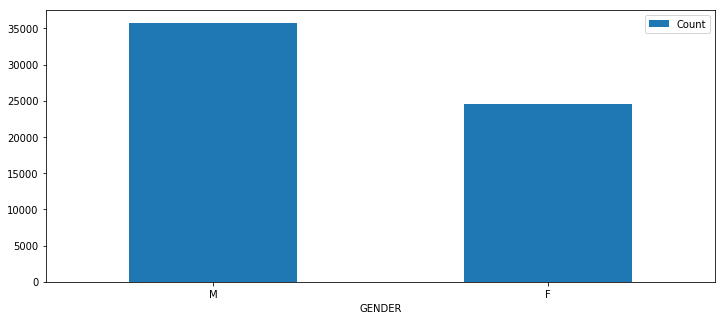

In [40]:
sales_df_plot.plot.bar(x="GENDER", y="Count", rot=0, figsize=(12, 5))  # Set the rot as 0 if you don't want the x ticks be 90 degrees rotated.

<a id="vizagg"></a>
### 6.2 Aggregate the data

You can do the equivalent job in the previous subsection in Spark by aggregating the data by `GENDER`. Here are a few of the ways that you can do that:

 - Run an SQL query on the GENDER column to output the count of the GENDER, and then run a group by operation on the GENDER.
 - Create a simple Python function to aggregate by GENDER, and then run the function in an SQL query.
 - Run the `map()` method on the Spark Dataframe to append a new column that contains the aggregated count by GENDER. 
 - Run the `groupBy()` and `count()` methods on the Spark Dataframe. This is the method you'll use.

In [41]:
gender_df = spark_df.groupBy("GENDER").count()

Check to verify that you get the expected results:

In [42]:
gender_df.show()

+------+-----+
|GENDER|count|
+------+-----+
|     F|24504|
|     M|35748|
+------+-----+



<a id="vizchart2"></a>
### 6.3 Create a chart using Spark SQL

Now, run an SQL query to group by `GENDER` and order by `GENDER`. Then, create a pandas DataFrame for the results and create a chart of the count of each gender.

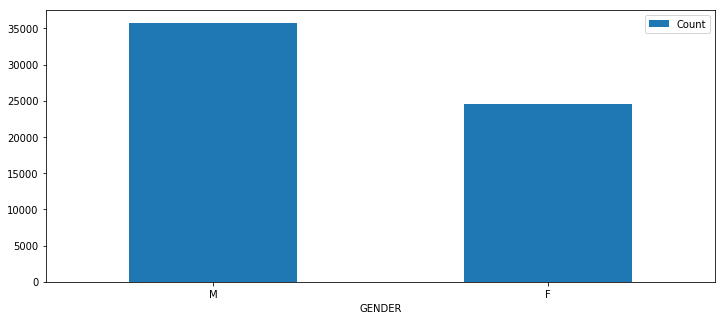

In [43]:
query = """
select
    GENDER,
    count(GENDER) as Count
from gosales_tx
group by GENDER
order by GENDER desc
"""
spark_gender_df = sqlContext.sql(query).toPandas()
spark_gender_df.plot.bar(x="GENDER", y="Count", rot=0, figsize=(12, 5));

Now you have a chart that is equivalent of the one in section [6.1 Create a chart](#vizchart).

<a id="nextsteps"></a>
## 7. Summary and next steps
You've learned how to create DataFrames, convert between DataFrame types, and convert from RDDs. You know how to run SQL queries and create SQL functions. And you can visualize the data in charts. 

Go to the next notebook in this series: <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/5ad1c820f57809ddec9a040e37b4af08" target="_blank" rel="noopener noreferrer">Introduction to Spark lab, part 3: Machine learning</a>.

Dig deeper:
 - <a href="http://spark.apache.org/documentation.html" target="_blank" rel="noopener noreferrer">Apache Spark documentation</a>
 - <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html" target="_blank" rel="noopener noreferrer">PySpark documentation</a>
 - <a href="http://pandas.pydata.org/pandas-docs/stable/index.html" target="_blank" rel="noopener noreferrer">pandas</a>
 - <a href="http://matplotlib.org/" target="_blank" rel="noopener noreferrer">matplotlib</a>
 - <a href="http://www.numpy.org/" target="_blank" rel="noopener noreferrer">NumPy</a>

### Authors
Carlo Appugliese is a Spark and Hadoop evangelist at IBM.<br>
Braden Callahan is a Big Data Technical Specialist for IBM.<br>
Ross Lewis is a Big Data Technical Sales Specialist for IBM.<br>
Mokhtar Kandil is a World Wide Big Data Technical Specialist for IBM.

### Data citation

The World Bank: Projects & Operations 

<hr>
Copyright &copy; IBM Corp. 2017-2019. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>